<a href="https://colab.research.google.com/github/OmdenaAI/IECO/blob/seife/LAM3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/IECO/'

/content/drive/MyDrive/Colab Notebooks/IECO


For 3D roof reconstruction, we need to prepare a dataset that can handle both aerial images and their corresponding 3D representations (e.g., point clouds or DSMs). Below is an implementation for a custom PyTorch Dataset class that loads and preprocesses this data.

**Step 1: Implementing the PyTorch Dataset Class**

Outline of the Custom Dataset Class

1. Dataset Structure: Each data sample should contain:
- An aerial image.
- A corresponding point cloud or digital surface model (DSM) for 3D information.

2. Dataset Initialization:
- Store paths to the images and DSM files.
- Apply any transformations for preprocessing images and DSMs.

3. Load and Transform Data:
- Load aerial images and convert them into PyTorch tensors.
- Load the DSM or point cloud data, which is also converted into a tensor format suitable for the model.
- Apply any augmentations if required.

In [24]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class RoofDataset(Dataset):
    def __init__(self, base_path, transform=None, dsm_transform=None, fixed_dsm_shape=(9807, 3)):
        """
        Args:
            base_path (str): Base directory containing subdirectories of paired images and DSM files.
            transform (callable, optional): Optional transform to be applied on the images.
            dsm_transform (callable, optional): Optional transform to be applied on the DSM or point cloud data.
            fixed_dsm_shape (tuple): Target shape for DSM tensors (points, dimensions).
        """
        self.image_paths = []
        self.point_cloud_paths = []
        self.transform = transform
        self.dsm_transform = dsm_transform
        self.fixed_dsm_shape = fixed_dsm_shape  # Target shape for DSM tensors

        # Populate image and point cloud paths based on directory structure
        for image_dir in os.listdir(base_path):
            image_path = os.path.join(base_path, image_dir)
            if os.path.isdir(image_path):
                img_path = os.path.join(image_path, 'google.jpg')
                point_cloud_path = os.path.join(image_path, 'dsm.json')

                # Check if both image and point cloud files exist
                if os.path.isfile(img_path) and os.path.isfile(point_cloud_path):
                    self.image_paths.append(img_path)
                    self.point_cloud_paths.append(point_cloud_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load aerial image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        # Apply transformations to the image, if any
        if self.transform:
            image = self.transform(image)

        # Load DSM or point cloud data
        dsm_path = self.point_cloud_paths[idx]
        with open(dsm_path, 'r') as f:
            dsm_data = np.array(json.load(f))  # Load DSM as numpy array

        # Pad or truncate DSM data to the fixed shape
        dsm_tensor = torch.zeros(self.fixed_dsm_shape, dtype=torch.float32)  # Start with a tensor of zeros
        num_points = min(dsm_data.shape[0], self.fixed_dsm_shape[0])         # Determine the number of points to copy
        dsm_tensor[:num_points, :] = torch.tensor(dsm_data[:num_points, :], dtype=torch.float32)  # Copy data

        # Apply transformations to the DSM data, if any
        if self.dsm_transform:
            dsm_tensor = self.dsm_transform(dsm_tensor)

        # Return both the image and DSM data
        return {'image': image, 'dsm': dsm_tensor}

# Example transforms for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the dataset with the base path
base_path = '/content/drive/MyDrive/Colab Notebooks/OmdenaIECO/Valid_Projects_Batch_1'
roof_dataset = RoofDataset(base_path=base_path, transform=image_transform)

# Check dataset content
sample = roof_dataset[0]  # Retrieve first sample
print("Image shape:", sample['image'].shape)  # Should be [3, 224, 224] if transformed
print("DSM shape:", sample['dsm'].shape)      # Should now be [9807, 3] as specified


Image shape: torch.Size([3, 224, 224])
DSM shape: torch.Size([9807, 3])


Let's take a look at the first aerial image example

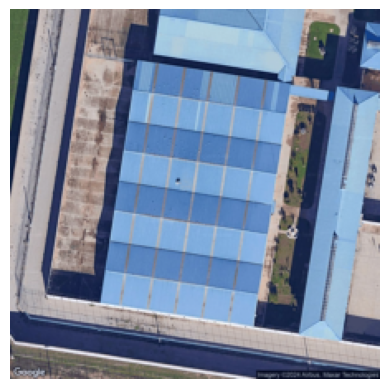

In [29]:
import numpy as np
import matplotlib.pyplot as plt

example = roof_dataset[10]
img_tensor_data = example['image']

# Convert to numpy array and transpose for visualization
image = img_tensor_data.numpy().transpose(1, 2, 0)

# Normalize values to 0-1 range for displaying
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

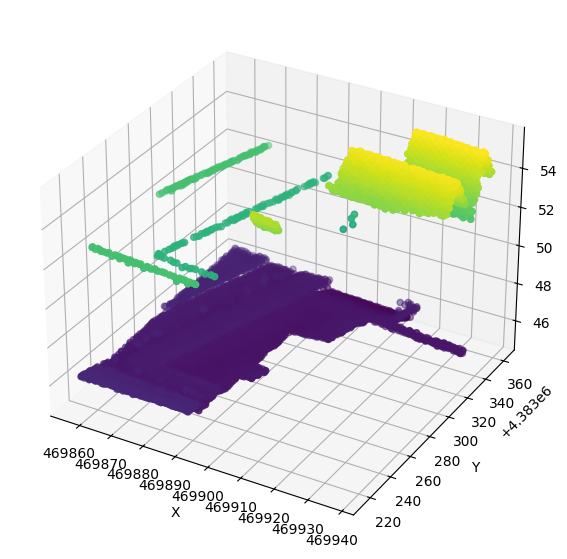

In [30]:
pcd_tensor_data = example['dsm']

# Convert tensor to numpy array for easier manipulation
point_cloud_np = pcd_tensor_data.numpy()

# Extract x, y, and z coordinates
x = point_cloud_np[:, 0]
y = point_cloud_np[:, 1]
z = point_cloud_np[:, 2]

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

**Step 2: Creating PyTorch DataLoaders**
The DataLoader will allow us to efficiently feed mini-batches of data to the model during training and evaluation. Here’s the outline for creating DataLoaders:
1. **Define Training and Validation Splits**:
Split the dataset into training and validation sets to evaluate model performance during training.
2. **Initialize DataLoaders**:
Use PyTorch’s DataLoader class to create DataLoaders for each split.
Specify parameters like batch_size, shuffle, and num_workers to control data loading behavior.


In [31]:
from torch.utils.data import DataLoader, random_split

# Define dataset split ratios (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for training and validation
total_samples = len(roof_dataset)
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(roof_dataset, [train_size, val_size])

# Define batch size and other DataLoader parameters
batch_size = 8  # You can adjust this based on memory constraints

# Initialize DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Check DataLoader batches
for batch in train_loader:
    print("Batch image shape:", batch['image'].shape)  # Expected: [batch_size, 3, 224, 224]
    print("Batch DSM shape:", batch['dsm'].shape)      # Expected: [batch_size, 9807, 3]
    break  # Only check the first batch for confirmation


Batch image shape: torch.Size([8, 3, 224, 224])
Batch DSM shape: torch.Size([8, 9807, 3])


**Step 3: Defining the Model.**

**Model Architecture Summary**
- `Image Feature Extractor`: Uses the DINOv2 model to process aerial images.
- `PointCloudTransformer`: Processes the point cloud to obtain latent representations.
- `Diffusion Model`: Combines image and point cloud features over time steps to align them.
- `TriPlaneDecoder`: Decodes the aligned features to obtain 3D representation values, like SDF

In [32]:
import torch.nn as nn
from transformers import AutoFeatureExtractor, Dinov2Model as DINOModel

# Ensure device is set to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Image Feature Extractor
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        self.feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/dino-vitb16")
        self.model = DINOModel.from_pretrained("facebook/dino-vitb16").to(device)

    def forward(self, images):
        with torch.no_grad():  # No gradients needed for pre-trained model
            features = self.model(images).last_hidden_state  # Shape: [batch_size, num_tokens, feature_dim]
        return features

# Define the Point Cloud Transformer
class PointCloudTransformer(nn.Module):
    def __init__(self, input_dim=3, latent_dim=256):
        super(PointCloudTransformer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, point_cloud):
        B, N, _ = point_cloud.shape
        point_cloud_flat = point_cloud.view(B * N, -1)
        x = self.relu(self.fc1(point_cloud_flat))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        tri_planes = x.view(B, N, -1)
        return tri_planes

# Define the Diffusion Model for alignment
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim=256, timesteps=1000, img_feature_dim=768):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.fc1 = nn.Linear(latent_dim + img_feature_dim, 128)
        self.fc2 = nn.Linear(128, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x, img_features, t):
        img_features = img_features.repeat_interleave(x.shape[1] // img_features.shape[1], dim=1)
        diff = x.shape[1] - img_features.shape[1]
        if diff > 0:
            padding = torch.zeros(img_features.shape[0], diff, img_features.shape[2], device=img_features.device)
            img_features = torch.cat([img_features, padding], dim=1)
        elif diff < 0:
            img_features = img_features[:, :x.shape[1], :]

        x = torch.cat([x, img_features], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Tri-Plane Decoder
class TriPlaneDecoder(nn.Module):
    def __init__(self, latent_dim=256, output_dim=1):
        super(TriPlaneDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, tri_plane):
        x = self.relu(self.fc1(tri_plane))
        x = self.relu(self.fc2(x))
        sdf_values = self.fc3(x)
        return sdf_values

# Define the Full Model combining all components
class Roof3DReconstructionModel(nn.Module):
    def __init__(self, latent_dim=256, img_feature_dim=768):
        super(Roof3DReconstructionModel, self).__init__()

        # Image Feature Extractor
        self.image_feature_extractor = ImageFeatureExtractor()

        # Point Cloud Transformer
        self.point_cloud_transformer = PointCloudTransformer(input_dim=3, latent_dim=latent_dim)

        # Diffusion Model for alignment
        self.diffusion_model = DiffusionModel(latent_dim=latent_dim, img_feature_dim=img_feature_dim)

        # Tri-Plane Decoder for 3D reconstruction
        self.tri_plane_decoder = TriPlaneDecoder(latent_dim=latent_dim, output_dim=1)

    def forward(self, images, point_clouds):
        # Step 1: Extract image features
        img_features = self.image_feature_extractor(images)

        # Step 2: Process point clouds to get latent tri-plane representations
        latent_tri_planes = self.point_cloud_transformer(point_clouds)

        # Step 3: Align image and point cloud features using the diffusion model
        aligned_features = self.diffusion_model(latent_tri_planes, img_features, t=1000)

        # Step 4: Decode aligned features to get SDF values (3D representation)
        sdf_values = self.tri_plane_decoder(aligned_features)

        return sdf_values

# Instantiate the model and move to device
model = Roof3DReconstructionModel().to(device)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
You are using a model of type vit to instantiate a model of type dinov2. This is not supported for all configurations of models and can yield errors.
Some weights of Dinov2Model were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['embeddings.mask_token', 'encoder.layer.0.layer_scale1.lambda1', 'encoder.layer.0.layer_scale2.lambda1', 'encoder.layer.0.mlp.fc1.bias', 'encoder.layer.0.mlp.fc1.weight', 'encoder.layer.0.mlp.fc2.bias', 'encoder.layer.0.mlp.fc2.weight', 'encoder.layer.0.norm1.bias', 'encoder.layer.0.norm1.weight', 'encoder.layer.0.norm2.bias', 'encoder.layer.0.norm2.weight', 'encoder.layer.1.layer_scale1.lambda1', 'encoder.layer.1.layer_scale2.lambda1', 'encoder.layer.1.mlp.fc1

**Testing the Model with a Forward Pass**

In [33]:
# Example forward pass with one batch
for batch in train_loader:
    images = batch['image'].to(device)
    point_clouds = batch['dsm'].to(device)

    # Forward pass
    sdf_values = model(images, point_clouds)
    print("SDF values shape:", sdf_values.shape)  # Expected shape depends on decoder output
    break  # Run only one batch for testing

SDF values shape: torch.Size([8, 9807, 1])


**Step 4: Training the Model.**

In this step, we’ll define the `training loop`, `loss function`, `optimizer`, and `hyperparameters` for training. Here’s the outline:

- Loss Function:

We can use a loss function suitable for 3D reconstruction, such as `Mean Squared Error` (MSE) Loss, which compares the predicted SDF values against target SDF values.
- Optimizer:

We’ll use Adam, a commonly used optimizer for deep learning tasks, and set the learning rate based on typical values.
- Training Loop:

Each epoch will consist of a forward pass, calculating the loss, and backpropagating to update the model weights.
We’ll also add a validation step to monitor the model’s performance on the validation dataset.

In [34]:
import torch.optim as optim

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # MSE Loss for SDF prediction
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Hyperparameters
num_epochs = 10  # Set based on your computational limits
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    # Training Phase
    for batch in train_loader:
        images = batch['image'].to(device)
        point_clouds = batch['dsm'].to(device)

        # Forward pass
        optimizer.zero_grad()  # Reset gradients
        sdf_pred = model(images, point_clouds)  # Predicted SDF values

        # Generate target SDF values if available
        # Replace this with actual target SDF values if you have them
        target_sdf = torch.zeros_like(sdf_pred)  # Placeholder for ground truth SDF

        # Calculate loss
        loss = loss_fn(sdf_pred, target_sdf)
        train_loss += loss.item() * images.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            point_clouds = batch['dsm'].to(device)

            # Forward pass
            sdf_pred = model(images, point_clouds)

            # Generate target SDF values for validation
            target_sdf = torch.zeros_like(sdf_pred)  # Placeholder for ground truth SDF

            # Calculate validation loss
            loss = loss_fn(sdf_pred, target_sdf)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/10], Train Loss: 16566676.9858, Val Loss: 1081731.8370
Epoch [2/10], Train Loss: 357474.4563, Val Loss: 137908.9990
Epoch [3/10], Train Loss: 20829.2912, Val Loss: 236.3149
Epoch [4/10], Train Loss: 259.4427, Val Loss: 24.8429
Epoch [5/10], Train Loss: 48.8694, Val Loss: 5.0276
Epoch [6/10], Train Loss: 15.8054, Val Loss: 3.4535
Epoch [7/10], Train Loss: 168.6849, Val Loss: 486.0861
Epoch [8/10], Train Loss: 781.3912, Val Loss: 386.9201
Epoch [9/10], Train Loss: 210.9080, Val Loss: 38.1092
Epoch [10/10], Train Loss: 53.7283, Val Loss: 11.9617
